# Predicting Comment Score

In [1]:
import pandas as pd; import numpy as np; 
from scipy.sparse import csr_matrix
import nltk
import math; import time
# import enchant; english_dict = enchant.Dict("en_US")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
#from html.parser import HTMLParser
from sklearn.cross_validation import StratifiedKFold
from sklearn import linear_model
from sklearn import metrics
# from stemming.porter2 import stem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                             stop_words = None, max_features = 5000) 

import seaborn
import matplotlib
from matplotlib import pyplot as plt
#from matplotlib import pylab
%matplotlib inline

#%pylab inline
#pylab.rcParams['figure.figsize'] = (20, 5)

# Tsne
from sklearn import manifold

# svd
from scipy.sparse.linalg import svds

In [2]:
font = {'weight' : 'normal',
        'size'   : 22}

axes = {'titlesize'  : 22,
        'labelsize'  : 22}

legend = {'fontsize'  : 22}

figure = {'figsize'  : (10,5)}

matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('legend', **legend)
matplotlib.rc('figure', **figure)

## 1 Data

### 1.1 Import cleaned comments

In [3]:
# Load previously generated files
LOAD = False

In [4]:
if LOAD:
    s_BOW = np.load('data/s_BOW.npy')
    s_TFI = np.load('data/s_TFI.npy')
    dft = pd.read_csv("data/finalnbanostop.csv")
else:
    from nba_data_types import load_nba
    (dft, s_BOW, s_TFI) = load_nba()
    np.save('data/s_BOW', s_BOW)
    np.save('data/s_TFI', s_TFI)
print(s_BOW.shape, s_TFI.shape)

(533919, 5000)
((533919, 5000), (533919, 5000))


In [5]:
# Remove points [0,3]
REMOVE = False
COMPRESS = False

if REMOVE:
    dft_small = dft[(dft['comment_score']<0) | (dft['comment_score']> 3)]
    (ind,) = (np.where((dft['comment_score']<0) | (dft['comment_score']> 3)))
    s_bow_small = s_BOW[ind,:]
    s_tfi_small = s_TFI[ind,:]
else:
    dft_small = dft
    s_bow_small = s_BOW
    s_tfi_small = s_TFI
    
if COMPRESS:
    d = 50
    
    U,S,V = svds(s_tfi_small.T,k=d,which='LM')
    s_tfi_small = s_tfi_small.dot(U)
    
print(s_bow_small.shape,s_tfi_small.shape)

((533919, 5000), (533919, 5000))


## number of features to use???

What values to use??
occurred in too many documents (max_df): don't need to worry about this one!
occurred in too few documents (min_df): 
were cut off by feature selection (max_features)



(array([  5.07961000e+05,   2.49640000e+04,   5.85000000e+02,
          1.27000000e+02,   5.40000000e+01,   2.00000000e+01,
          6.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([ -457. ,    41.7,   540.4,  1039.1,  1537.8,  2036.5,  2535.2,
         3033.9,  3532.6,  4031.3,  4530. ]),
 <a list of 10 Patch objects>)

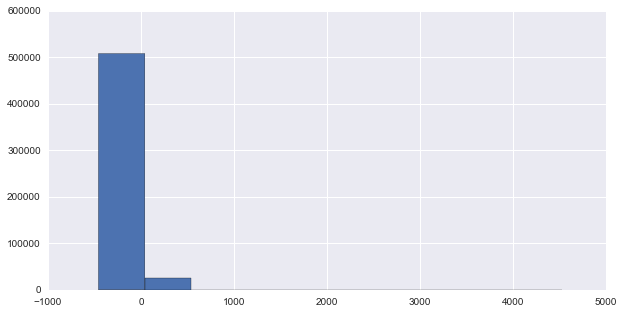

In [6]:
plt.hist(dft['comment_score'])

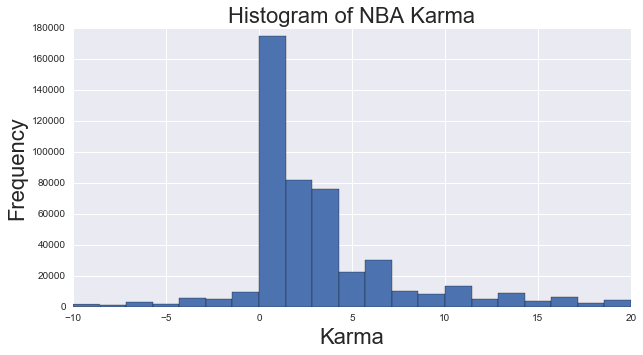

In [7]:
plt.hist(dft['comment_score'],21,range=[-10, 20])
plt.title('Histogram of NBA Karma')
plt.xlabel('Karma')
plt.ylabel('Frequency')

# Clustering

## Regression

1. Remove points [0, 3]
3. Types of regressions

Ridge, Lasso, RF regression, SVR, Linear
CV

Expect RF to be best b/c euclidian distance assumption doesn't work

### Normalize by the score of the post

not doing this!!

In [8]:


#s = np.copy(dft_small['score'])
#s[s==0.0] = 0.1
#a = np.divide(dft_small['comment_score'],s)
#print(max(a), np.percentile(a,.25), np.percentile(a,.5), np.percentile(a,.75))



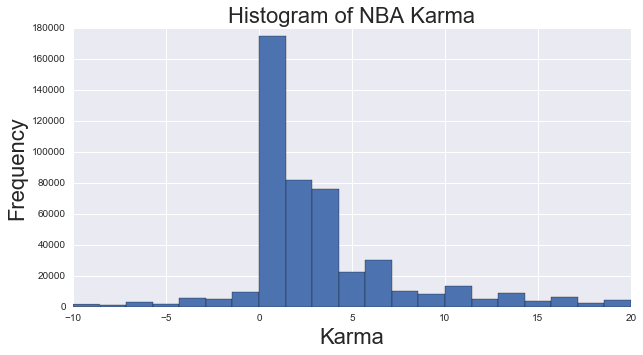

In [9]:
plt.hist(dft_small['comment_score'],bins=21,range=[-10, 20])
if REMOVE:
    plt.title('Histogram of NBA Karma without [0,3]')
else:
    plt.title('Histogram of NBA Karma')
plt.xlabel('Karma')
plt.ylabel('Frequency')

## Regresssion

In [10]:
ltype = 'TFI'

In [11]:
scores = []
for row in dft['comment_score']:
    scores.append((row))
    
scores = np.array(scores)
if REMOVE:
    scores_small = scores[ind]
else:
    scores_small = scores

# there are only 200 ~ score of 200 so set them all to 200
scores_small[scores_small > 200] = 201
scores_small[scores_small < -50] = -51

In [12]:
print(scores_small.shape)

(533722,)


In [13]:
from scipy.sparse import hstack

# Normalize variance
for times

In [14]:
def norm_feature(train, test):
    var = np.var(train)
    mean = np.mean(train)
    
    train[np.isnan(train)] = 0
    test[np.isnan(test)] = 0
    
    train = np.reshape((train-mean)/var, (len(train),1))
    test = np.reshape((test-mean)/var,(len(test),1))
    return(train, test, var, mean)

In [15]:
# Dimensionality reduction on s_bow_small

In [16]:
k = 10
skf = StratifiedKFold(scores_small,n_folds=k, shuffle=True)

for train_i,test_i in skf:
    if ltype == 'BOW':
        X_val = s_bow_small[test_i,:]
        X = s_bow_small[train_i,:]
    elif ltype == 'TFI':
        X_val = s_tfi_small[test_i,:]
        X = s_tfi_small[train_i,:]
    
    time_ind_val = dft['timedifference'][test_i]
    time_ind = dft['timedifference'][train_i]
    score_ind_val = dft['score'][test_i]
    score_ind = dft['score'][train_i]
        
    Y_val = scores_small[test_i]
    Y = scores_small[train_i]
    break;
    
(score_ind, score_ind_val,_,_) = norm_feature(score_ind, score_ind_val)
(time_ind, time_ind_val,_,_) = norm_feature(time_ind, time_ind_val)


X_val = csr_matrix(hstack((X_val, time_ind_val,score_ind_val)))
X = csr_matrix(hstack((X, time_ind,score_ind)))
print(X_val.shape, X.shape)

((53483, 5002), (480239, 5002))


# MAKE SMALL DATASET FOR NOW!!!

In [17]:
X = X_val
Y = Y_val

In [18]:
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import kernel_ridge
from sklearn import ensemble

In [ ]:
# Ridge, Lasso, RF regression, SVR, Linear
models = {"Linear":linear_model.LinearRegression(normalize=True),
          "Ridge": linear_model.Ridge(alpha = 1000, fit_intercept=True, normalize=True),
          "LassoCV": linear_model.Lasso(alpha = 10,fit_intercept=True, normalize=True,
                                      selection='random',max_iter=1000), 
          "SVR": svm.LinearSVR(),
          #"Gradesc": linear_model.SGDRegressor(penalty="l1",n_iter=15),
          "DTree": tree.DecisionTreeRegressor(max_depth=40), 
          "RF": ensemble.RandomForestRegressor(max_depth=40,n_estimators=16)
          #"B.Ridge": linear_model.BayesianRidge(),
          #"ABoost": ensemble.AdaBoostRegressor(),
          }

k = 10
skf = StratifiedKFold(Y,n_folds=k, shuffle=True)

mse = {}
runtimes = {}
r2 = {}
for name in models.keys():
    mse[name] = np.empty((k,))
    runtimes[name] = np.empty((k,))
    r2[name] = np.empty((k,))

i = 0
alphas = np.linspace(0.005,.4,5)
print('Trial\t\t'+'\t\t'.join(models.keys()))


for train_i, test_i in skf:

    print(i)
    
    X_train, X_test = X[train_i,:],X[test_i,:]
    Y_train, Y_test = Y[train_i], Y[test_i]
        
    for name,model in models.iteritems():
        start_time = time.time()  
        fitted_model = model.fit(X_train, Y_train)            

        Y_pred = fitted_model.predict(X_test)
        tim = time.time() - start_time
        runtimes[name][i] = tim
        mse[name][i] = metrics.mean_squared_error(Y_test, Y_pred)
        r2[name][i] = metrics.r2_score(Y_test, Y_pred)
    

    mse_print = 'MSE\t\t'
    time_print = 'Time\t\t'
    r2_print = 'r2\t\t'
    for name in models.keys():
        mse_print = mse_print + format('%1.3f'%mse[name][i])+"\t" 
        time_print = time_print + format('%1.3f'%runtimes[name][i]) + "\t\t"
        r2_print = r2_print + format('%1.3f'%r2[name][i]) + "\t\t"
    print(mse_print)
    print(time_print)
    print(r2_print)
    i = i+1
    
for name in models.keys():
    print name + " " + str(np.average(mse[name]))
    print name + " " + str(np.average(runtimes[name]))
    print name + " " + str(np.average(r2[name]))

In [ ]:
for name in models.keys():
    plt.plot(mse[name],label=name)
plt.title('MSE')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.ylim([0,4])
plt.legend()

## Take a look at a specific one

In [ ]:
for train_i, test_i in skf:
    X_train, X_test = X[train_i,:],X[test_i,:]
    Y_train, Y_test = Y[train_i], Y[test_i]
    
    model = linear_model.Lasso(alpha=0.261, fit_intercept=True, normalize=True,
                                          selection='random',max_iter=1000)
    fitted_model = model.fit(X_train, Y_train)
    Y_pred = fitted_model.predict(X_test)
    break
plt.plot(Y_test)
plt.plot(Y_pred)

In [ ]:
print(np.percentile(Y_pred,.25),np.percentile(Y_pred,.5),np.percentile(Y_pred,.75))

# Classification

Note: we will set the following boundaries according to score:

Bad: <= 0

Neutral: 1

Good: 2, 3, 4

Very Good: >= 5

In [ ]:
import pickle
word2vec = pickle.load(open('word2vec.p','rb'))

In [19]:
# categorize each comment by score
def categorize(score):
    if score<=-5:
        return -2
    elif score>-5 and score < -1:
        return -1
    elif score >= -1 and score <= 2:
        return 0
    elif score >= 2 and score < 10:
        return 1
    elif score >= 10:# and score <=100:
        return 2
#    else:
#        return 3

In [32]:
ltype = 'BOW'
print(REMOVE)

False


In [33]:
labels = []
for row in dft['comment_score']:
    labels.append(categorize(row))
labels = np.array(labels)

if REMOVE:
    labels_small = labels[ind]
else:
    labels_small = labels

In [34]:
def norm_class_feature(train, test):
    """Noramlization of a feature for classifiers
    Features must be non negative!"""
    #var = np.var(train)
    #mean = np.mean(train)
    
    train[np.isnan(train)] = 0
    test[np.isnan(test)] = 0
    
    #train = (train-mean)/var
    #train = (train-min(train))/(max(train)-min(train))
    #test = (test-mean)/var
    #test = (test-min(test))/(max(test)-min(test))
    
    train = np.reshape(train, (len(train),1))
    test = np.reshape(test,(len(test),1))
    return(train, test)#, var, mean)

In [35]:
print(labels_small.shape, s_tfi_small.shape)

((533722,), (533919, 5000))


In [36]:
print(X_val.shape, time_ind_val.shape)

((53375, 5001), (53375, 1))


In [37]:
k = 10
skf = StratifiedKFold(labels_small,n_folds=k, shuffle=True)

for train_i,test_i in skf:
    if ltype == 'BOW':
        X_val = s_bow_small[test_i,:]
        X = s_bow_small[train_i,:]
    elif ltype == 'TFI':
        X_val = s_tfi_small[test_i,:]
        X = s_tfi_small[train_i,:]
    elif ltype == 'W2V':
        X_val = word2vec[test_i,:]
        X = word2vec[train_i,:]
    
    time_ind_val = dft['timedifference'][test_i]
    time_ind = dft['timedifference'][train_i]
    score_ind_val = dft['score'][test_i]
    score_ind = dft['score'][train_i]
        
    Y_val = labels_small[test_i]
    Y = labels_small[train_i]
    break;
    
(score_ind, score_ind_val) = norm_class_feature(score_ind, score_ind_val)
(time_ind, time_ind_val) = norm_class_feature(time_ind, time_ind_val)


# X_val = csr_matrix(hstack((X_val, time_ind_val,score_ind_val)))
# X = csr_matrix(hstack((X, time_ind,score_ind)))
X_val = csr_matrix(hstack((X_val, time_ind_val)))
X = csr_matrix(hstack((X, time_ind)))

print(X_val.shape, X.shape)

((53375, 5001), (480347, 5001))


In [38]:
# TAKE 10% OF DATA!!!
X = X_val
Y = Y_val

# Take an equal amount from each section

ind = np.array([])
for i in range(-2,3):
    ind = np.concatenate((ind,np.random.choice(np.where(Y==i)[0], size = 10000)))
    ind = [int(x) for x in ind]

X = X[ind,:]
Y = Y[ind]

In [39]:
print(sum([Y==3][0]), sum([Y==2][0]), sum([Y==1][0]),sum([Y==0][0]),sum([Y==-1][0]), sum([Y==-2][0]))

(0, 10000, 10000, 10000, 10000, 10000)


In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Hyperparameter Optimization
# Grid Search
from sklearn.grid_search import GridSearchCV

mnb = MultinomialNB()
knn = KNeighborsClassifier()
lsvc = LinearSVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lor = LogisticRegression()

# # Hyperparameter optimization for LinearSVC using Grid Search Cross-Validation
# C_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# max_iter_range = [100, 500, 1000]
# parameters = {"C":C_range, "max_iter":max_iter_range}
# clf = GridSearchCV(lsvc, parameters)
# clf.fit(X, Y)
# print("The best classifier is: ", clf.best_estimator_)

# # Hyperparameter optimization for KNN using Grid Search Cross-Validation
# parameters = [{'weights': ['uniform', 'distance'], 'n_neighbors': [5, 10], 'leaf_size': [10,20]}]
# clf = GridSearchCV(knn, parameters)
# clf.fit(X, Y)
# print("The best classifier is: ", clf.best_estimator_)

# # Hyperparameter optimization for Decision Tree using Grid Search Cross-Validation
# parameters = [{'max_features': ['auto', 'log2'], 'max_depth': [10,20,30,40,50,60,70,80,90,100,200,500,1000]}]
# clf = GridSearchCV(dt, parameters)
# clf.fit(X, Y)
# print("The best classifier is: ", clf.best_estimator_)

# # Hyperparameter optimization for Random Forest using Grid Search Cross-Validation
# parameters = [{"n_estimators": [5, 10, 20, 50, 100]}]
# clf = GridSearchCV(rf, parameters)
# clf.fit(X, Y)
# print("The best classifier is: ", clf.best_estimator_)

In [41]:
models = {"MNB": MultinomialNB(),
          "KNN": KNeighborsClassifier(n_neighbors=5, leaf_size = 10, weights='uniform'), 
          "LSV": LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=500,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 
          #"RBF": SVC(kernel='rbf'),
          "DFT": DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1000,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          "RFC": RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 
          "LOR": LogisticRegression(),
          }

Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The C parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving the model freedom to select more samples as support vectors.

http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [42]:
k = 10
skf = StratifiedKFold(Y,n_folds=k, shuffle=True)

nNeighbors = range(3,20,3)
Cs = np.logspace(-5,0,10)
C_rbf = np.logspace(-2, 10, 13)
gamma_rbf = np.logspace(-9, 3, 13)

accuracies = {}
f1scores = {}
precisions = {}
recalls = {}
runtimes = {}
for name in models.keys():
    accuracies[name] = np.empty((k,))
    f1scores[name] = np.empty((k,))
    precisions[name] = np.empty((k,))
    recalls[name] = np.empty((k,))
    runtimes[name] = np.empty((k,))
    
print('Trial\t\t'+'\t\t'.join(models.keys()))

i = 0

for train_i, test_i in skf:
    print(i)
    X_train, X_test = X[train_i,:],X[test_i,:]
    Y_train, Y_test = Y[train_i], Y[test_i]
        
    for name,model in models.iteritems():
        start_time = time.time()
        
        if name == 'pKNN':
            cv_ac = np.empty((len(nNeighbors),))
            for n_i,n in enumerate(nNeighbors):
                model.n_neighbors = n
                fitted_model = model.fit(X_train,Y_train)
                Y_pred = fitted_model.predict(X_test)
                cv_ac[n_i] = metrics.accuracy_score(Y_test, Y_pred)
            max_i = np.where(cv_ac==max(cv_ac))[0][0]
            print(name + (' Neighbors = %1.3f' % nNeighbors[max_i]))
            model.set_params(n_neighbors=nNeighbors[max_i])
        elif name == 'pLOR':
            cv_ac = np.empty((len(Cs),))
            for n_i,n in enumerate(Cs):
                model.set_params(C=n)
                fitted_model = model.fit(X_train,Y_train)
                Y_pred = fitted_model.predict(X_test)
                cv_ac[n_i] = metrics.accuracy_score(Y_test, Y_pred)
            max_i = np.where(cv_ac==max(cv_ac))[0][0]
            print(name + (' C = %1.3f' % Cs[max_i]))
            model.set_params(C=Cs[max_i])
        elif name == 'pRBF':
            cv_pre = np.empty((len(C_rbf),len(gamma_rbf)))
            for c_i,c in enumerate(C_rbf):
                for g_i, g in enumerate(gamma_rbf):
                    model.set_params(C=c,gamma=g)
                    fitted_model = model.fit(X_train,Y_train)
                    Y_pred = fitted_model.predict(X_test)
                    cv_pre[c_i,g_i] = metrics.precision_score(Y_test, Y_pred)
            idx = np.where(cv_pre==max(cv_pre))
            max_i,max_j = idx[0][0], idx[1][0]
            print(name + (' C = %1.3f, gamma = %1.3f' % (C_rbf[max_i],gamma_rbf[max_j])))
            model.set_params(C=C_rbf[max_i],gamma = gamma_rbf[max_j])
                
        fitted_model = model.fit(X_train, Y_train)
        Y_pred = fitted_model.predict(X_test)
        tim = time.time() - start_time
        
        accuracies[name][i] = metrics.accuracy_score(Y_test, Y_pred)
        f1scores[name][i] = metrics.f1_score(Y_test, Y_pred,average='weighted')
        precisions[name][i] = metrics.precision_score(Y_test, Y_pred,average='weighted')
        recalls[name][i] = metrics.recall_score(Y_test, Y_pred,average='weighted')
        runtimes[name][i] = tim
    
    ac_print = 'AC'
    f1scores_print = 'F1'
    precisions_print = 'Prec'
    recalls_print = 'Recall'
    time_print = 'Time'
    for name in models.keys():
        ac_print = ac_print + "\t\t" + format('%1.3f'%accuracies[name][i])
        f1scores_print = f1scores_print + "\t\t" + format('%1.3f'%f1scores[name][i])
        precisions_print = precisions_print + "\t\t" + format('%1.3f'%precisions[name][i])
        recalls_print = recalls_print + "\t\t" + format('%1.3f'%recalls[name][i])
        time_print = time_print + "\t\t" + format('%1.3f'%runtimes[name][i])
    print(ac_print)
    print(f1scores_print)
    print(precisions_print)
    print(recalls_print)
    print(time_print)
    
    i = i+1


Trial		KNN		RFC		DFT		LSV		LOR		MNB
0
AC		0.604		0.783		0.758		0.204		0.200		0.418
F1		0.573		0.777		0.752		0.132		0.067		0.412
Prec		0.569		0.774		0.749		0.168		0.140		0.416
Recall		0.604		0.783		0.758		0.204		0.200		0.418
Time		19.098		58.115		1.286		18.616		0.205		0.013
1
AC		0.605		0.774		0.767		0.203		0.199		0.395
F1		0.573		0.769		0.760		0.166		0.067		0.394
Prec		0.568		0.765		0.757		0.192		0.040		0.406
Recall		0.605		0.774		0.767		0.203		0.199		0.395
Time		18.718		54.887		1.257		17.923		0.203		0.014
2
AC		0.600		0.779		0.722		0.200		0.200		0.404
F1		0.568		0.773		0.719		0.110		0.067		0.400
Prec		0.562		0.770		0.719		0.219		0.107		0.411
Recall		0.600		0.779		0.722		0.200		0.200		0.404
Time		14.833		56.431		1.222		22.027		0.208		0.015
3
AC		0.608		0.774		0.770		0.204		0.200		0.393
F1		0.577		0.769		0.763		0.146		0.067		0.389
Prec		0.573		0.765		0.760		0.187		0.040		0.397
Recall		0.608		0.774		0.770		0.204		0.200		0.393
Time		15.697		55.583		1.416		20.688		0.198		0.016
4
AC		0.604	

In [43]:
print('Means')
for name in models.keys():
    print(name+(' AC %1.3f\tF1: %1.3f\tPrecision: %1.3f\tRecall: %1.3f\t Time: %1.3f\t'
          %(np.mean(accuracies[name]),np.mean(f1scores[name]),np.mean(precisions[name]),
            np.mean(recalls[name]),np.mean(runtimes[name]))))

Means
KNN AC 0.602	F1: 0.569	Precision: 0.565	Recall: 0.602	 Time: 18.182	
RFC AC 0.778	F1: 0.773	Precision: 0.770	Recall: 0.778	 Time: 57.595	
DFT AC 0.759	F1: 0.752	Precision: 0.749	Recall: 0.759	 Time: 1.351	
LSV AC 0.198	F1: 0.119	Precision: 0.176	Recall: 0.198	 Time: 22.151	
LOR AC 0.200	F1: 0.067	Precision: 0.117	Recall: 0.200	 Time: 0.222	
MNB AC 0.403	F1: 0.398	Precision: 0.405	Recall: 0.403	 Time: 0.015	


In [44]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

k = 10
skf = StratifiedKFold(Y,n_folds=k, shuffle=True)

for train_i, test_i in skf:
    X_train, X_test = X[train_i,:],X[test_i,:]
    Y_train, Y_test = Y[train_i], Y[test_i]
    break
    
Y_pred = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False).fit(X_train, Y_train).predict(X_test)


In [49]:
np.unique(Y_pred)

array([-2, -1,  0,  1,  2])

Confusion matrix, without normalization
[[ 998    0    1    0    1]
 [   0 1000    0    0    0]
 [  42   39  561  185  173]
 [  25   17  202  639  117]
 [  19   16  141  116  708]]


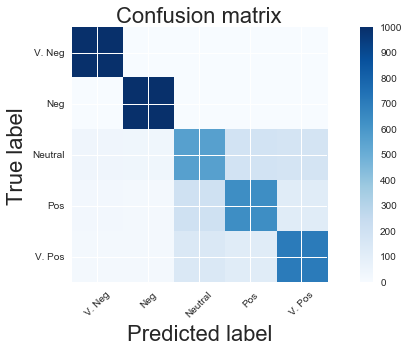

In [53]:


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    #names = ['-2','-1','0','1','2']
    names = ['V. Neg','Neg','Neutral','Pos','V. Pos']
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)



Normalized confusion matrix
[[ 1.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.04  0.04  0.56  0.18  0.17]
 [ 0.03  0.02  0.2   0.64  0.12]
 [ 0.02  0.02  0.14  0.12  0.71]]


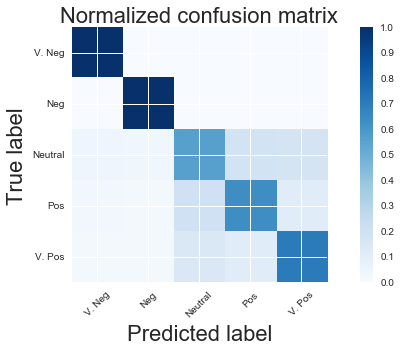

In [51]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()